In [1]:
import os
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [2]:
seed = 42
path = "data/train/"
diags = [x for x in os.listdir(path) if x.startswith("dialogues_pt")]

In [3]:
X, y = [], []
for f in diags:
    with open(os.path.join(path,f), 'r') as file:
        data = json.load(file)
    for i, dialog in enumerate(data):
        y.append(dialog['services'])
        sp = []
        for turn in dialog['turns']:
            if f.endswith('015.json') and i == 0:
                print(turn['speaker'], ': ', turn['utterance_pt'], '\n', sep='')
            sp.append(turn['utterance_pt'])
        X.append(' '.join(sp))

USER: Estou procurando algo divertido para fazer na parte sul da cidade. Você tem alguma sugestão sobre uma grande atração?

SYSTEM: Você pode conferir o museu de arte byard.

USER: Claro, posso aprender mais sobre isso?

SYSTEM: É um museu em King&#39;s Parade. Não há taxa de entrada. O número de telefone é 01223464646 para verificar suas atrações atuais.

USER: Obrigado, há algum restaurante caro nessa mesma área?

SYSTEM: Sim, que tipo de comida você procura?

USER: O restaurante deve servir comida turca.

SYSTEM: não há nenhum que sirva comida turca, podemos procurar outro lugar?

USER: Que tal comida chinesa? Existe algum disponível para isso?

SYSTEM: Sim, existem dois restaurantes disponíveis. O Good Luck Chinese food takeaway e o restaurante Pequim. São adequados?

USER: Vamos com o restaurante Pequim. Você pode reservar uma mesa para 6 pessoas às 18:30 na segunda-feira, por favor?

SYSTEM: Lamento, mas não consigo fazer essa reserva. Posso fazer mais alguma coisa por você?

US

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=.25, random_state=seed)

In [5]:
with open("stopwords.txt") as f:
    stopw = f.read().split()
cvec = TfidfVectorizer(stop_words=stopw)
xtrain_vec = cvec.fit_transform(xtrain)

In [6]:
tsne = TSNE(random_state=seed)
xtrain_tsne = tsne.fit_transform(xtrain_vec)
utterances = list(set([item for sublist in y for item in sublist]))
y_pseudo = [[1 if ut in y else 0 for y in ytrain] for ut in utterances]

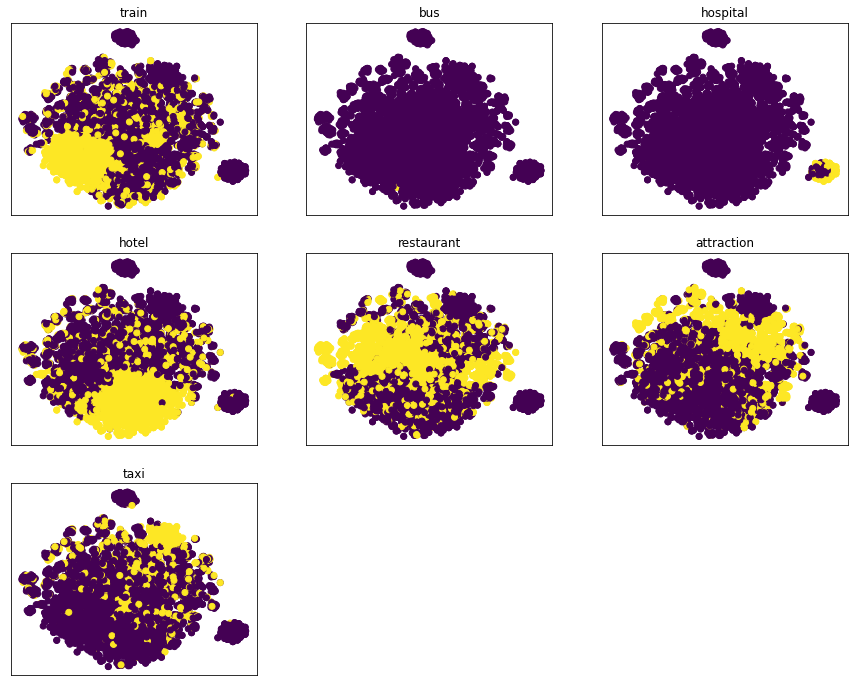

In [7]:
sizeut = len(utterances)
fig, axes = plt.subplots(3, sizeut//3+1, figsize=(15, 12), sharex=True)
axes = axes.flatten()
for i in range(3*(sizeut//3+1)):
    if i >= sizeut:
        axes[i].axis('off')
    else:
        axes[i].set_title(utterances[i])
        axes[i].scatter(xtrain_tsne[:,0], xtrain_tsne[:,1], c=y_pseudo[i]);
        axes[i].set_xticks([])
        axes[i].set_yticks([])

In [8]:
lda = LatentDirichletAllocation(n_components=5, random_state=seed)
topics = lda.fit_transform(xtrain_vec)

In [9]:
df = pd.DataFrame(topics)
df['y'] = ytrain

In [10]:
sample = df.sample(20, random_state=seed)
sample.style.background_gradient(cmap='Reds', axis=1)\
      .format({x:"{:0.3f}" for x in range(10)})

,0,1,2,3,4,y
1057,0.023,0.314,0.024,0.024,0.615,"['attraction', 'train']"
5865,0.020,0.021,0.918,0.020,0.021,"['attraction', 'hotel']"
3197,0.029,0.883,0.029,0.029,0.030,['restaurant']
3560,0.021,0.544,0.022,0.021,0.392,"['attraction', 'train']"
4352,0.034,0.035,0.035,0.534,0.362,[]
4254,0.024,0.024,0.904,0.024,0.024,['hotel']
2664,0.017,0.932,0.017,0.017,0.017,"['restaurant', 'hotel']"
6276,0.028,0.029,0.887,0.028,0.029,['hotel']
3667,0.030,0.350,0.031,0.559,0.031,['hospital']
2868,0.028,0.886,0.029,0.028,0.029,['taxi']


In [11]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

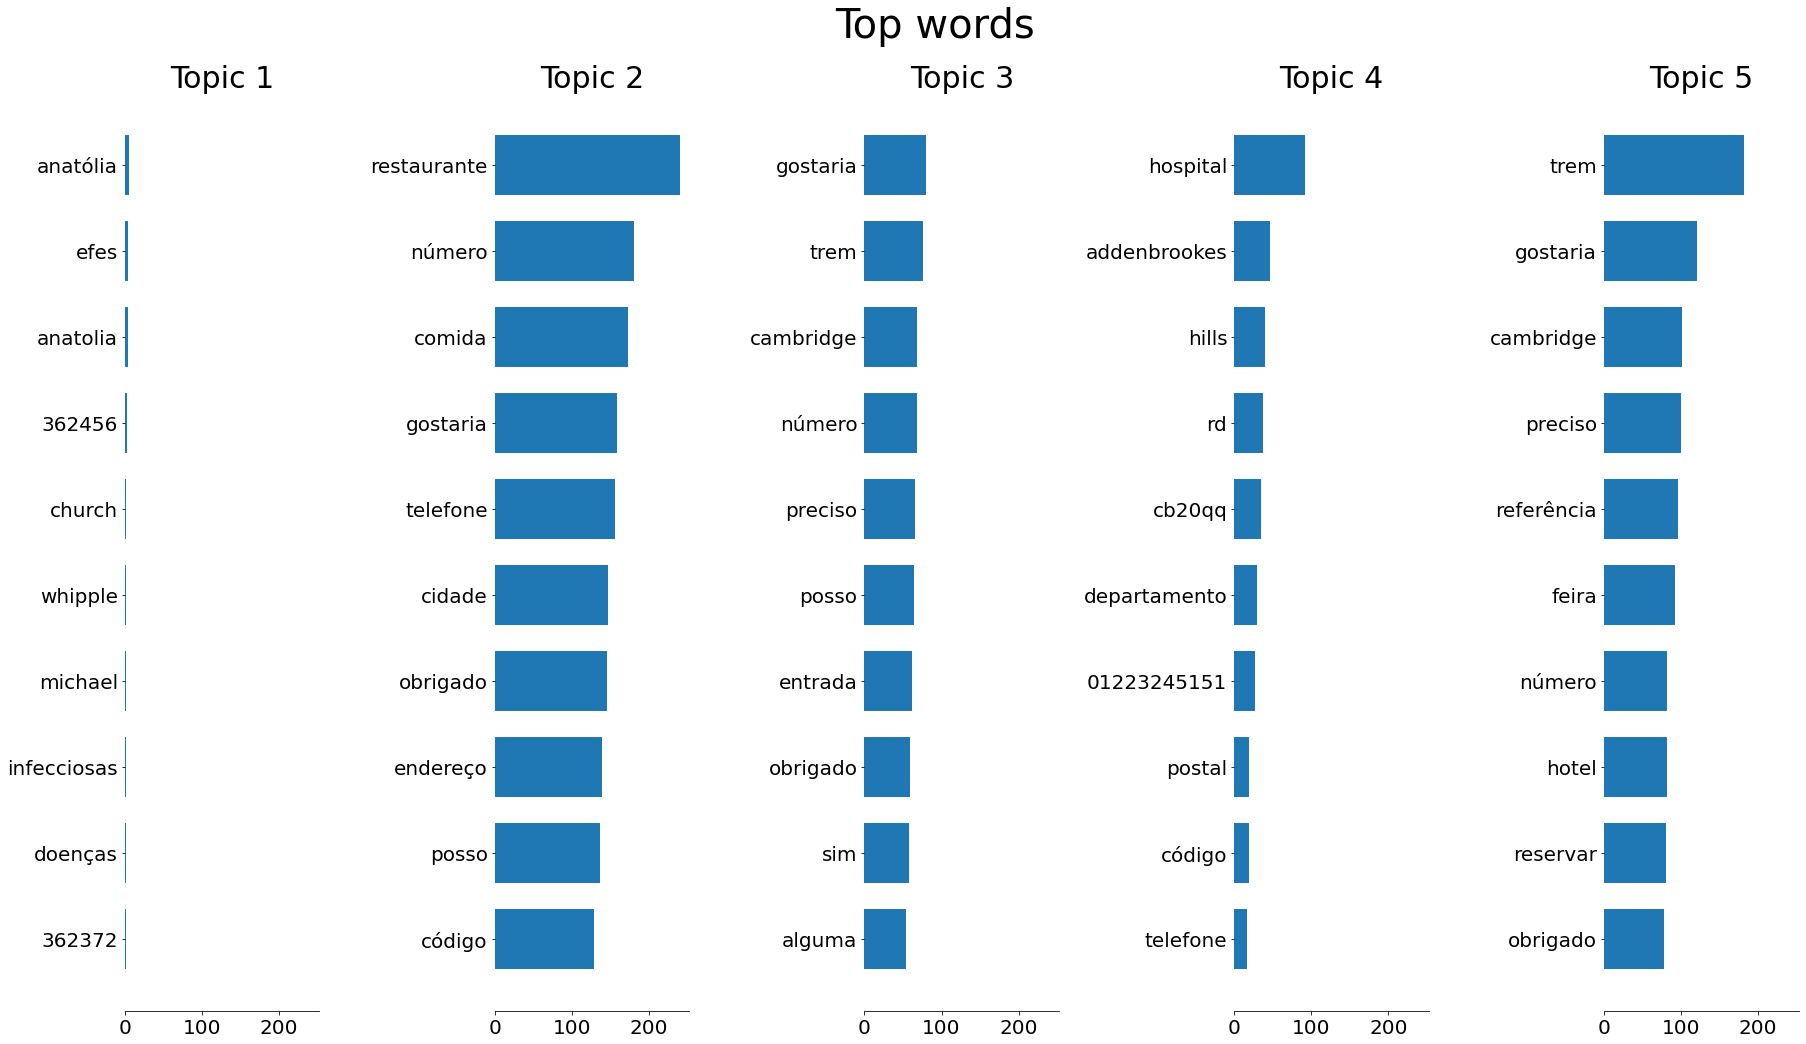

In [12]:
plot_top_words(lda, cvec.get_feature_names(), 10, "Top words")

In [13]:
ytopic = ['.'.join(i) if i else 'universal' for i in y]
train_size = int(len(y)*.8)
val_size = int(len(y)*.1)
test_size = len(y) - (train_size+val_size)
partition = ['train']*train_size + ['val']*val_size + ['test']*test_size
random.shuffle(partition)
df = pd.DataFrame({'text':X, 'partition':partition, 'topic':ytopic})
df[~df['topic'].str.contains("bus")].to_csv('data/corpus.tsv', sep='\t',
                                            index=False, header=False)
with open('data/vocabulary.txt', 'w') as fout:
    for word in cvec.vocabulary_.keys():
        fout.write(word+'\n')

In [14]:
from octis.evaluation_metrics.classification_metrics import AccuracyScore
from octis.dataset.dataset import Dataset
from octis.models.LDA import LDA
from octis.models.ProdLDA import ProdLDA
from octis.models.CTM import CTM

In [15]:
dataset = Dataset()
dataset.load_custom_dataset_from_folder('data/')
model1 = LDA(num_topics=8, alpha=0.1)
model2 = ProdLDA(num_topics=8)
model3 = CTM(num_topics=8)

In [16]:
acc = AccuracyScore(dataset)

In [17]:
for m in [model1, model2, model3]:
    output = m.train_model(dataset)
    print(acc.score(output))

KeyError: 'attraction.restaurant.taxi.hotel'